In [73]:
import zipfile
import os
import shutil
import random
import numpy as np
import signal
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from keras.callbacks import TensorBoard
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam
from google.colab import files
from IPython.display import Image

import io

In [52]:
path_zip = '/content/drive/MyDrive/data/state-farm-distracted-driver-detection.zip'
path_extracted_files = '/content/extracted_files/'

In [53]:
# Unzip the zip file state-farm-distracted-driver-detection.zip

# If the zip has been already uncompressed, it doesn't do it again
if os.path.exists(path_extracted_files):
    print("The zip file has already been extracted")
else:
    with zipfile.ZipFile(path_zip, 'r') as zip_ref:
        zip_ref.extractall("/content/extracted_files")

The zip file has already been extracted


In [54]:
# Delete the file driver_imgs_list.csv and sample_submission.csv
if os.path.exists(path_extracted_files + 'driver_imgs_list.csv'):
    os.remove(path_extracted_files + 'driver_imgs_list.csv')

if os.path.exists(path_extracted_files + 'sample_submission.csv'):
    os.remove(path_extracted_files + 'sample_submission.csv')

In [55]:
# Delete the folder imgs/test and its images
if os.path.exists(path_extracted_files + 'imgs/test'):
    shutil.rmtree(path_extracted_files + 'imgs/test')

In [56]:
# Make 2 directories named test and train in the content directory with the same folders that are in the train directory
if os.path.exists(path_extracted_files + 'test'):
    print("The directories have already been created")
else:
    os.makedirs(path_extracted_files + 'test')
    os.makedirs(path_extracted_files + 'train')

    # Get folders inside 'train'
    folders = os.listdir(path_extracted_files + 'imgs/train')

    for folder in folders:
        os.makedirs(path_extracted_files + f'test/{folder}')
        os.makedirs(path_extracted_files + f'train/{folder}')

The directories have already been created


In [57]:
# From the initial train directory, generate a new train and test directories, comprising 85% and 15% of the images respectively
folders = os.listdir(path_extracted_files + 'imgs/train')

# Check if the content/imgs/train/c0 folder is empty
if len(os.listdir(path_extracted_files + 'imgs/train/c0')) != 0:

    # Iterate through each folder (c0-c9) in the train directory
    for folder in os.listdir(path_extracted_files + 'imgs/train'):

        # List all images in the current folder
        images = os.listdir(path_extracted_files + f'imgs/train/{folder}')

        # Shuffle the list of images randomly
        random.shuffle(images)

        # Calculate the number of images to move to the test directory (15% of total)
        n = int(len(images) * 0.15)

        # Select the first n images as test images
        test_images = images[:n]

        # Move the selected test images to the test directory
        for img in test_images:
            shutil.move(path_extracted_files + f'imgs/train/{folder}/{img}', path_extracted_files + f'test/{folder}/{img}')

    # Move the remaining 85% of the images to the train directory
    for folder in os.listdir(path_extracted_files + 'imgs/train'):

        # List all images in the current folder
        images = os.listdir(path_extracted_files + f'imgs/train/{folder}')

        # Shuffle the list of images randomly
        random.shuffle(images)

        # Move all images to the train directory
        for img in images:
            shutil.move(path_extracted_files + f'imgs/train/{folder}/{img}', path_extracted_files + f'train/{folder}/{img}')
else:
    print("The images have already been moved")

The images have already been moved


In [58]:
train_datagen = ImageDataGenerator(
    # We scale pixels between 0 and 1
    rescale = 1./255,
    validation_split = 0.1)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    # We define the directory where the training images are located
    path_extracted_files + 'train',
    # We transform all images to 96 x 96
    target_size=(96, 96),
    # We group the images into batches of 128
    batch_size=128,
    # We specify that the images remain in color (RGB)
    color_mode='rgb',
    # We define a categorical class type
    class_mode='categorical')

test_datagen = ImageDataGenerator(
    rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    # We define the directory where the test images are located
    path_extracted_files + 'test',
    # We transform all images to 96 x 96
    target_size=(96, 96),
    # We specify that the images remain in color (RGB)
    color_mode='rgb',
    # We define a categorical class type
    class_mode='categorical')

Found 19066 images belonging to 10 classes.
Found 3358 images belonging to 10 classes.


In [59]:
# Definition of the image sizes
input_size = 96
num_colors = 3

# Definition of the network layers
layers = [
    # First convolution with 16 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(16,
                        (3,3),
                        activation='relu',
                        input_shape=(input_size,
                                    input_size,
                                    num_colors)),
    # Pooling of size 2 x 2 and stride 1
    keras.layers.MaxPooling2D(2, 2),
    # Second convolution with 32 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(32,
                        (3,3),
                        activation='relu'),
    # Pooling of size 2 x 2 and stride 1
    keras.layers.MaxPooling2D(2,2),
    # Third convolution with 64 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(64,
                        (3,3),
                        activation='relu'),
    # Pooling of size 2 x 2 and stride 1
    keras.layers.MaxPooling2D(2,2),
    # Flattening to transform the information into a vector
    keras.layers.Flatten(),
    # Dense layer with 512 neurons and relu activation function
    keras.layers.Dense(512,
                       activation='relu'),
    # Output layer with softmax activation function
    keras.layers.Dense(10,
                       activation = tf.nn.softmax),
]

model = keras.Sequential(layers, name="multi-class_classification")

In [60]:
# Optimization algorithm and loss function configuration
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Network structure
model.summary()

Model: "multi-class_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 47, 47, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 22, 22, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 10, 

In [61]:
'''
learning_rate = 0.01

# Create an instance of the Adam optimizer with your desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile your model with the optimizer
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Network structure
model.summary()
'''

"\nlearning_rate = 0.01\n\n# Create an instance of the Adam optimizer with your desired learning rate\noptimizer = Adam(learning_rate=learning_rate)\n\n# Compile your model with the optimizer\nmodel.compile(optimizer=optimizer,\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\n# Network structure\nmodel.summary()\n"

In [62]:
# Definition of the TF Board callback
tensorboard_callback = TensorBoard(
    log_dir = 'logs')

# Training process execution
# Iterations: 15
# Number of steps per iteration: 4
history = model.fit(train_generator,
                    steps_per_epoch = 4,
                    epochs = 50,
                    callbacks = [tensorboard_callback])

# Evaluation of the model using the test set
results = model.evaluate(test_generator)

print(results)

Epoch 1/50
4/4 [==============================] - 3s 107ms/step - loss: 2.3315 - accuracy: 0.1035
Epoch 2/50
4/4 [==============================] - 1s 267ms/step - loss: 2.2789 - accuracy: 0.1250
Epoch 3/50
4/4 [==============================] - 2s 452ms/step - loss: 2.2258 - accuracy: 0.2461
Epoch 4/50
4/4 [==============================] - 3s 863ms/step - loss: 2.1127 - accuracy: 0.3574
Epoch 5/50
4/4 [==============================] - 3s 581ms/step - loss: 1.9407 - accuracy: 0.3418
Epoch 6/50
4/4 [==============================] - 2s 478ms/step - loss: 1.7980 - accuracy: 0.3652
Epoch 7/50
4/4 [==============================] - 2s 490ms/step - loss: 1.6351 - accuracy: 0.4219
Epoch 8/50
4/4 [==============================] - 2s 572ms/step - loss: 1.5005 - accuracy: 0.5195
Epoch 9/50
4/4 [==============================] - 3s 772ms/step - loss: 1.3511 - accuracy: 0.5508
Epoch 10/50
4/4 [==============================] - 1s 269ms/step - loss: 1.1252 - accuracy: 0.6680
Epoch 11/50
4/4 [==

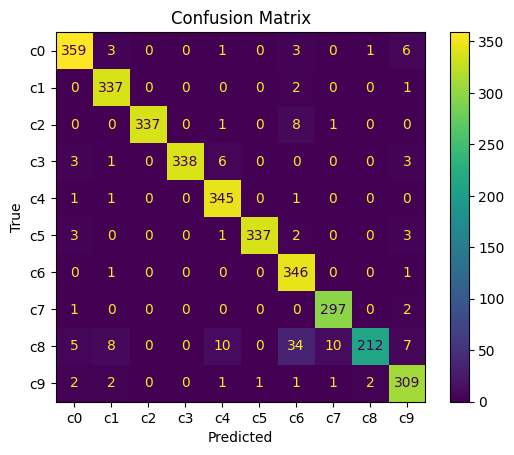

In [63]:
predictions = []
true_labels = []

# Iterate over each batch in the test generator
for i in range(len(test_generator)):
    # Get batch of data and labels and predict on it
    batch_data, batch_labels = test_generator[i]
    batch_predictions = model.predict(batch_data, verbose=0)
    # Append predictions and true labels
    predictions.extend(np.argmax(batch_predictions, axis=1))
    true_labels.extend(np.argmax(batch_labels, axis=1))

cm = confusion_matrix(true_labels, predictions)
labels = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Saving img_1.jpg to img_1.jpg


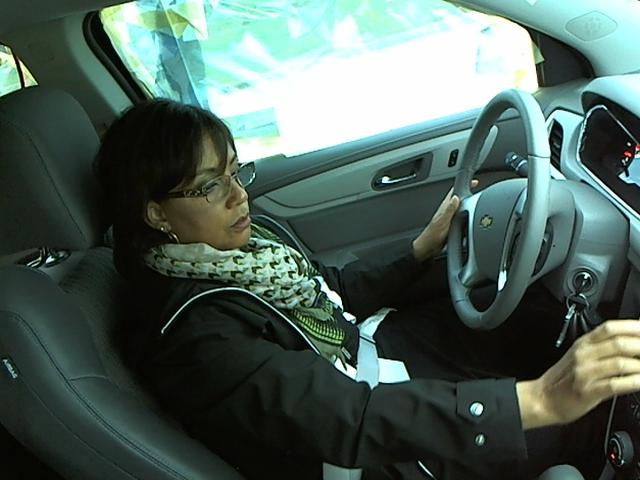

1/1 [==============================] - 0s 19ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
img_1.jpg is classified as:
   - operating the radio with probability 1.0
   - talking to passenger with probability 0.0
   - hair and makeup with probability 0.0


In [96]:
label_names = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
minimum_value = 0.78

# We use the file insertion system of Colab
uploaded = files.upload()

for filename, filedata in uploaded.items():
    # Display the image using IPython.display.Image
    display(Image(data=filedata, width=300))

    # Image path configuration
    path = '/content/' + filename

    # Preprocess the image
    img = image.load_img(path, target_size=(96, 96))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Image transformation into a tensor
    image_tensor = np.vstack([x])

    # Inference execution
    classes = model.predict(image_tensor)
    print(classes)

    # Get the indices of top three classes
    top_three_indices = np.argsort(classes[0])[::-1][:3]

    # Print the top three classes and their probabilities
    print(f"{filename} is classified as:")
    for i in top_three_indices:
        print(f"   - {label_names[i]} with probability {classes[0][i]}")

    # If no class meets the threshold
    if not any(classes[0][i] > minimum_value for i in range(len(classes[0]))):
        print(filename + ' is not classified in any class.')
